In [38]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter#%%
from lifelines.utils import k_fold_cross_validation
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
medal_detailed = pd.read_excel('yearly_detailed_medal.xlsx')

In [3]:
medal_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20970 entries, 0 to 20969
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      20970 non-null  int64  
 1   NOC             20970 non-null  object 
 2   Year            20970 non-null  int64  
 3   Sport           20970 non-null  object 
 4   Athletes_Count  20970 non-null  int64  
 5   Gold            20970 non-null  int64  
 6   Silver          20970 non-null  int64  
 7   Bronze          20970 non-null  int64  
 8   Total_Medals    20970 non-null  int64  
 9   Events_Count    20970 non-null  int64  
 10  Gold rate       20970 non-null  float64
 11  Silver rate     20970 non-null  float64
 12  Bronze rate     20970 non-null  float64
 13  Medal rate      20970 non-null  float64
dtypes: float64(4), int64(8), object(2)
memory usage: 2.2+ MB


In [4]:
medal_detailed['Awarded'] = ((medal_detailed['Gold'] > 0) | 
                          (medal_detailed['Silver'] > 0) | 
                          (medal_detailed['Bronze'] > 0)).astype(int)

In [5]:
first_participation_year = medal_detailed.groupby('NOC')['Year'].min().reset_index()
first_participation_year = first_participation_year.rename(columns={'Year': 'First_Participation_Year'})
first_award_year = medal_detailed[medal_detailed['Awarded'] == 1].groupby('NOC')['Year'].min().reset_index()
first_award_year.columns = ['NOC', 'First_Award_Year']

In [6]:
# 如果该国没有获奖，则生存时间设为 NaN 或其他大值
country_summary = pd.merge(first_participation_year, first_award_year, on='NOC', how='left')
country_summary['Time_to_Award'] = country_summary['First_Award_Year'] - country_summary['First_Participation_Year']

# 对于未获奖的国家，Time_to_Award 可以设为 NaN
country_summary['Time_to_Award'] = country_summary['Time_to_Award'].fillna(-1).astype(int)

添加特征

In [242]:
country_summary

,NOC,First_Participation_Year,First_Award_Year,Time_to_Award,Athletes_Count,Events_Count,Awarded
0,AFG,1936,2008.0,72,-0.415284,-0.714324,1
1,AHO,1952,1988.0,36,-0.451381,-0.721852,1
2,AIN,2024,2024.0,0,-0.470557,-1.317661,1
3,ALB,1972,2024.0,52,-0.447432,-0.388457,1
4,ALG,1968,1984.0,16,-0.197015,0.521389,1
...,...,...,...,...,...,...,...
227,YEM,1992,NaN,-1,-0.469429,-0.643343,0
228,YMD,1988,NaN,-1,-0.490297,-1.366057,0
229,YUG,1920,1948.0,28,0.146464,-0.000213,1
230,ZAM,1964,1984.0,20,-0.354372,-0.147552,1


In [7]:
country_participation = medal_detailed.groupby('NOC')['Year'].nunique().reset_index()
max_participation = country_participation['Year'].max()
country_participation['Participation_Frequency'] = country_participation['Year'] / max_participation
events_diversity = medal_detailed.groupby('NOC')['Sport'].nunique().reset_index()
events_diversity.rename(columns={'Sport': 'Events_Diversity'}, inplace=True)

In [8]:
# 如果该国在任何年份获奖，则 Awarded = 1，否则为 0
award_data = medal_detailed[medal_detailed['Awarded'] == 1]
award_countries = award_data.groupby('NOC').agg({'Year': 'min'}).reset_index()
award_countries['Awarded'] = 1  # 设定该国家为已获奖
award_countries = award_countries[['NOC', 'Awarded']]

country_summary = pd.merge(country_summary, medal_detailed.groupby('NOC').agg({
    'Athletes_Count': 'sum',  # 汇总运动员人数
    'Events_Count': 'sum'     # 汇总参赛项目数
}).reset_index(), on='NOC', how='left')

country_summary = pd.merge(country_summary, award_countries, on='NOC', how='left')

country_summary['Awarded'] = country_summary['Awarded'].fillna(0).astype(int)

# 查看汇总后的结果
print(country_summary.head())

   NOC  First_Participation_Year  First_Award_Year  Time_to_Award  \
0  AFG                      1936            2008.0             72   
1  AHO                      1952            1988.0             36   
2  AIN                      2024            2024.0              0   
3  ALB                      1972            2024.0             52   
4  ALG                      1968            1984.0             16   

   Athletes_Count  Events_Count  Awarded  
0             138           660        1  
1              74           653        1  
2              40            99        1  
3              81           963        1  
4             525          1809        1  


In [9]:
from sklearn.preprocessing import StandardScaler

# 初始化 StandardScaler
scaler = StandardScaler()
# 对 'Athletes_Count' 和 'Events_Count' 进行标准化
country_summary[['Athletes_Count', 'Events_Count']] = scaler.fit_transform(
    country_summary[['Athletes_Count', 'Events_Count']]
)
country_summary = pd.merge(country_summary, country_participation[['NOC', 'Participation_Frequency']], on='NOC', how='left')
country_summary['Participation_Frequency'] = scaler.fit_transform(country_summary[['Participation_Frequency']])
country_summary = pd.merge(country_summary, events_diversity[['NOC', 'Events_Diversity']], on='NOC', how='left')
country_summary['Events_Diversity'] = scaler.fit_transform(country_summary[['Events_Diversity']])

In [10]:
award_countries_summary = country_summary[(country_summary['Time_to_Award'] >36)&(country_summary['Awarded'] ==1)]

In [11]:
no_award_countries_summary = country_summary[country_summary['Awarded'] == 0]

In [12]:
# 选择特征变量
X = award_countries_summary[['Athletes_Count','Events_Count','Events_Diversity','Participation_Frequency']]  # 选择一些特征来预测

# 合并生存时间和事件标记
survival_data = pd.concat([X,award_countries_summary[['Time_to_Award', 'Awarded']]], axis=1)

# 使用 Cox Proportional Hazards Model 进行生存分析
cph = CoxPHFitter(penalizer=0.1)

# 训练模型
cph.fit(survival_data, duration_col='Time_to_Award', event_col='Awarded')

# 查看模型结果
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 19 total observations, 0 right-censored observations>
             duration col = 'Time_to_Award'
                event col = 'Awarded'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 19
number of events observed = 19
   partial log-likelihood = -36.47
         time fit was run = 2025-01-26 08:44:59 UTC

---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                
Athletes_Count           0.19      1.21      0.50           -0.78            1.16                0.46                3.20
Events_Count             0.73      2.07      0.73           -0.71            2.16                0.49                8.66
Events_Diversity        -0.59      0.55      0.56           -1.70            0.51                0.18                1.66
Participation_Frequency  0.73      2.07      0.51           -0.27            1.73                0.76                5.63

                         cmp to     z    p  -log2(p)
covariate                                           
Athletes_Count             0.00  0.38 0.70      0.51
Events_Count               0.00  0.99 0.32      1.64
Events_Diversity           0.00 -1.05 0.29      1.78
Participation_Frequency    0.00  1.42 0.15      2.70
---
Concordance = 0.71
Partial AIC = 80.93
log-likelihood ratio test = 5.75 on 4 df
-log2(p) of ll-ratio test = 2.19

In [16]:
scores1 = k_fold_cross_validation(cph, survival_data, duration_col='Time_to_Award', event_col='Awarded', k=5)
# 查看交叉验证的结果
print("Cross-validation scores:")
print(scores1)
scores2=cph.concordance_index_
print("C-index")
print(scores2)

Cross-validation scores:
[-4.164765822604193, -0.6186582518313299, -0.9249318395383563, -0.9476061037689014, -0.7377746358533158]
C-index
0.7685185185185185


<Axes: xlabel='HR (95% CI)'>

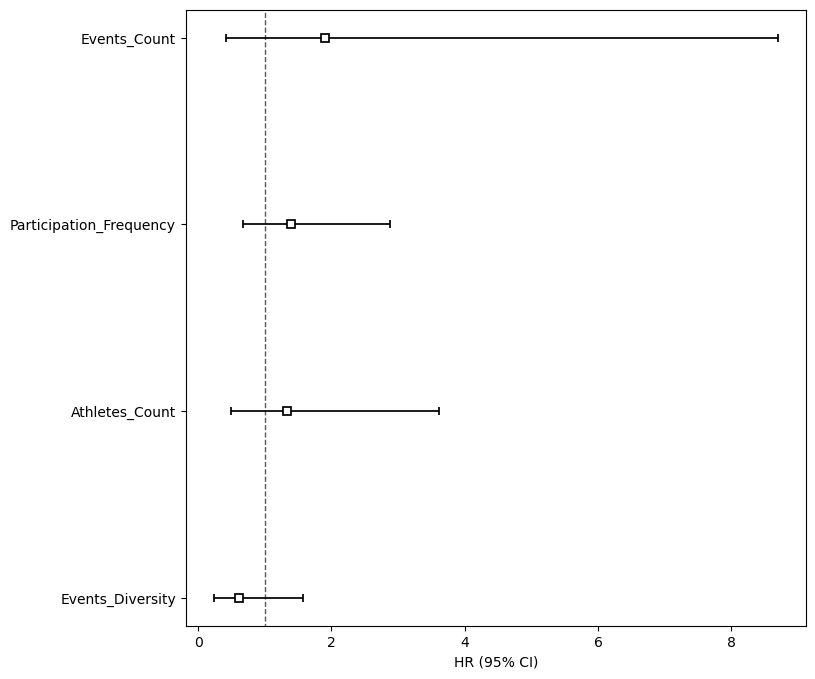

In [302]:
#画出每个协变量的HR值和95%置信度区间（森林图)
plt.figure(figsize=(8,8))
cph.plot(hazard_ratios=True)

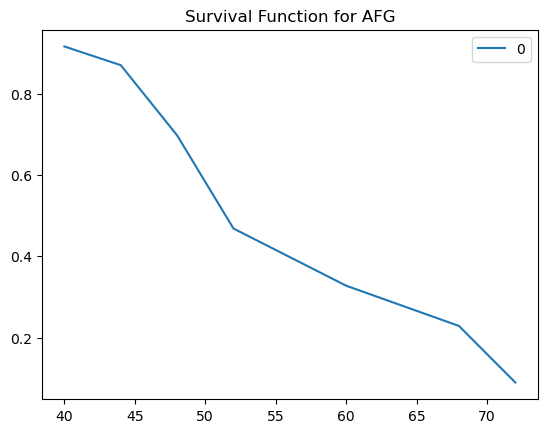

In [303]:
import matplotlib.pyplot as plt

# 获取特定国家（例如 AFG）的生存函数
survival_function = cph.predict_survival_function(award_countries_summary.loc[award_countries_summary['NOC'] == 'AFG'])

# 绘制生存函数
survival_function.plot()
plt.title("Survival Function for AFG")
plt.show()#%%

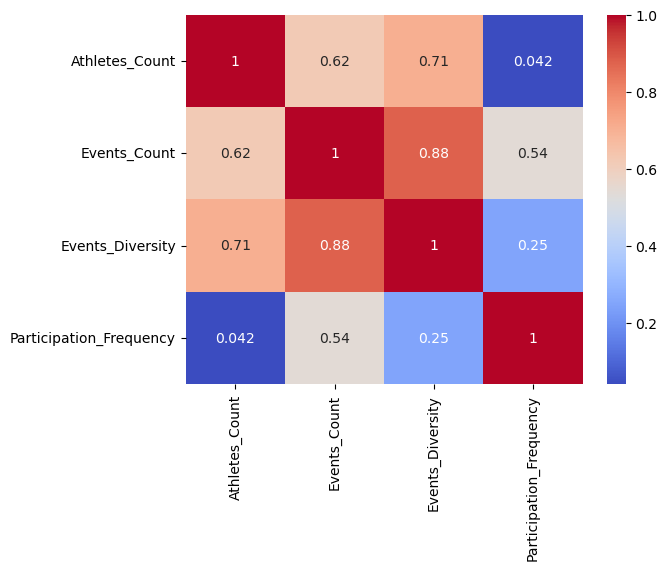

In [304]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算相关矩阵
corr_matrix = X.corr()

# 绘制热力图
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [43]:
# 计算每个国家从首次参赛到 2028 年的时间间隔
no_award_countries_summary['Years_since_first_competition'] = 2028 - no_award_countries_summary['First_Participation_Year']

# 生成时间间隔从 10 年到 130 年，每年一个时间点
time_intervals = np.arange(5, 131, 1)  # 从10到130年，每年一个时间点

# 初始化一个列表来存储每个国家的生存函数
survival_at_2028 = []

# 对每个国家，根据其时间跨度（Years_since_first_competition）从生存函数中获取对应的生存概率
for index, row in no_award_countries_summary.iterrows():
    time_since_first = row['Years_since_first_competition']
    
    # 获取该国家的生存函数
    survival_func = cph.predict_survival_function(row[['Athletes_Count', 'Events_Count', 'Events_Diversity', 'Participation_Frequency']].values.reshape(1, -1), times=time_intervals)
    
    # 预测该国家在 2028 年的生存概率（即未获奖的概率）
    # 提取生存函数中对应于该国家时间跨度的生存概率
    if time_since_first >= 5 and time_since_first <= 130:
        survival_at_2028.append(survival_func.loc[time_since_first].values[0])
    else:
        # 如果国家的时间跨度不在10到130年之间，可以选择不处理，或者给出默认值
        survival_at_2028.append(np.nan)  # 或者设置为其他值，如 0 或 1，根据具体需求

# 将预测的生存概率添加到 DataFrame 中
no_award_countries_summary['Survival_at_2028'] = survival_at_2028

C:\Users\zhaochenghao\AppData\Local\Temp\ipykernel_67544\2836008843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_award_countries_summary['Years_since_first_competition'] = 2028 - no_award_countries_summary['First_Participation_Year']
C:\Users\zhaochenghao\AppData\Local\Temp\ipykernel_67544\2836008843.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_award_countries_summary['Survival_at_2028'] = survival_at_2028


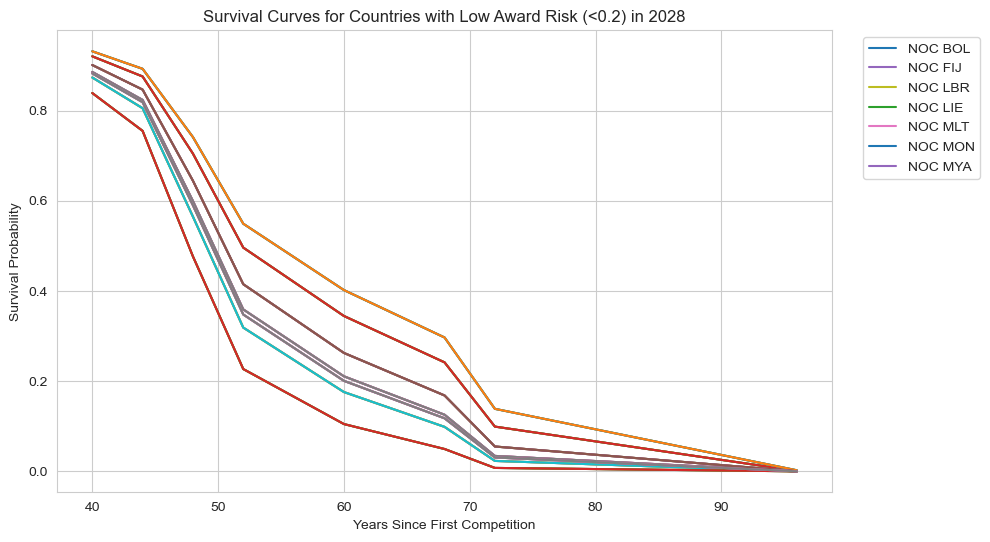

In [53]:
# 筛选出生存概率低于0.2的国家
low_risk_countries = no_award_countries_summary[no_award_countries_summary['Survival_at_2028'] < 0.2]

# 获取低风险国家的生存曲线
plt.figure(figsize=(10, 6))

for index, row in low_risk_countries.iterrows():
    # 获取该国家的生存函数
    survival_function = cph.predict_survival_function(row[['Athletes_Count', 'Events_Count', 'Events_Diversity', 'Participation_Frequency']].values)
    
    # survival_function 是一个 DataFrame，其索引是时间点，values 是生存概率
    for i in range(survival_function.shape[1]):  # 遍历所有列，每一列表示一个国家
        plt.plot(survival_function.index, survival_function.values[:, i], label=f"NOC {row['NOC']}" if i == 0 else "")  # 只给第一条曲线加标签

# 格式化图表
plt.title('Survival Curves for Countries with Low Award Risk (<0.2) in 2028')
plt.xlabel('Years Since First Competition')
plt.ylabel('Survival Probability')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

In [54]:
no_award_countries_summary.to_csv('no_award_countries_summary.csv')
low_risk_countries.to_csv('low_risk_countries.csv')